# Setup

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import humanize
import time
import cufflinks as cf
cf.go_offline()

pd.set_option('display.max_rows', 100)

In [2]:
from functools import wraps

# It provides time taken by a function
def print_timing(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        t1 = time.perf_counter()
        result = func(*args, **kwargs)
        print(f"{func.__name__} took {humanize.naturaldelta(time.perf_counter()-t1)}")
        return result
    return wrapper
    
    
    

# Data Setup

In [3]:
@print_timing
def data_setup():
    df_cooper = pd.read_parquet(r'D:\Users\Garwal\code\runs\0df80349-2a9c-40c7-874d-5f9cdd9bb992\results\common_df_cooper.parquet')
    df_abb = pd.read_parquet(r'D:\Users\Garwal\code\runs\aaa7787c-8b38-4dc9-877b-5ac702bad1bb\results\common_df_abb.parquet')

    print("Cooper dataset size", df_cooper.shape)
    print("ABB dataset size", df_abb.shape)

    common_cols = list(set(df_cooper.columns.tolist()).intersection(set(df_abb.columns.tolist())))
    df_cooper = df_cooper[common_cols]
    df_abb = df_abb[common_cols]
    df = pd.concat([df_cooper, df_abb], axis=0)
    df['duplicate_payment_category'] = df['duplicate_payment_category'].replace('','BLANK')
    df['duplicate_invoice_category'] = df['duplicate_invoice_category'].replace('','BLANK')

    del df_cooper, df_abb

    # common_cols_eda = {}
    # for col in sorted(common_cols):
    #     common_cols_eda[col]= {'dtype':df[col].dtype,'nunique':df[col].nunique(),'na':df[col].isna().sum()}
    print("Combined dataset size", df.shape)
    print(f"Total data size {humanize.naturalsize(df.memory_usage(deep=True).sum())}")
    print(f"Total columns {len(df.columns)}")
    return df



In [4]:
df = data_setup()

Cooper dataset size (889142, 55)
ABB dataset size (4273130, 59)
Combined dataset size (5162272, 35)
Total data size 2.9 GB
Total columns 35
data_setup took 8 seconds


In [5]:
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols

['P2P00073',
 'P2P00161',
 'Recurring_AmountValue',
 'P2P00149',
 'ScheduledPayDate_PaymentClearedDate_diff',
 'P2P00123',
 'P2P00121',
 'target',
 'P2P00160',
 'VendorCreatedDate_PaymentApprovedDate_diff',
 'PaymentCurrencyCode_cpi_rank',
 'SPT_RowID',
 'P2P00024',
 'ScheduledPayDate_PaymentApprovedDate_diff',
 'VendorCreatedDate_PaymentClearedDate_diff',
 'P2P00155',
 'P2P00088',
 'VendorCountry_cpi_rank',
 'duplicate_invoice_count',
 'P2P00074',
 'duplicate_payment_count',
 'P2P00047',
 'P2P00003',
 'VendorCreatedDate_ScheduledPayDate_diff',
 'P2P00089',
 'P2P00086',
 'P2P00093',
 'Recurring_no_of_payments',
 'PaymentApprovedDate_PaymentClearedDate_diff']

In [6]:
other_cols = filter(lambda x: x not in num_cols, df.columns)
list(other_cols)

['duplicate_invoice_category',
 'RemitAddress',
 'RemitCountry_rank',
 'type_of_target',
 'PaymentCurrencyCode_rank',
 'duplicate_payment_category']

In [7]:
df.drop(['SPT_RowID', 
         'type_of_target',
 'RemitAddress',
 'duplicate_invoice_category',
 'PaymentCurrencyCode_rank',
 'RemitCountry_rank',
 'duplicate_payment_category'], axis=1, inplace=True)

In [8]:
corr = df.corr()
corr = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
df_corr = corr.stack().reset_index()
df_corr.columns = ['feature1', 'feature2', 'corr_coef']
df_corr['corr_coef'] = abs(df_corr['corr_coef'])
df_corr.sort_values('corr_coef', ascending=False)

C:\Users\Mkhare\AppData\Local\Temp\ipykernel_32392\1445539649.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,feature1,feature2,corr_coef
267,ScheduledPayDate_PaymentApprovedDate_diff,VendorCreatedDate_ScheduledPayDate_diff,0.984255
230,PaymentCurrencyCode_cpi_rank,VendorCountry_cpi_rank,0.927399
133,P2P00123,P2P00155,0.918339
109,ScheduledPayDate_PaymentClearedDate_diff,ScheduledPayDate_PaymentApprovedDate_diff,0.917708
286,VendorCreatedDate_PaymentClearedDate_diff,PaymentApprovedDate_PaymentClearedDate_diff,0.910970
...,...,...,...
63,Recurring_AmountValue,VendorCreatedDate_PaymentClearedDate_diff,0.000163
45,P2P00161,P2P00047,0.000159
305,P2P00088,P2P00003,0.000156
126,P2P00123,target,0.000099


In [9]:
len(df_corr)

378

In [10]:
df_corr['corr_coef'].value_counts(bins=np.arange(0,1.1,0.1)).sort_index()

(-0.001, 0.1]    312
(0.1, 0.2]        45
(0.2, 0.3]         6
(0.3, 0.4]         3
(0.4, 0.5]         2
(0.5, 0.6]         2
(0.6, 0.7]         1
(0.7, 0.8]         1
(0.8, 0.9]         0
(0.9, 1.0]         6
Name: corr_coef, dtype: int64

In [11]:
df_high_corr = df_corr[df_corr['corr_coef']>=.8]
high_corrs = df_high_corr['feature1'].tolist() + df_high_corr['feature1'].tolist()
high_corr_cols = pd.Series(high_corrs)
high_corr_cols.value_counts().idxmax()

'ScheduledPayDate_PaymentClearedDate_diff'

# Remove high correlations

In [12]:
def remove_high_correlations(df, cols_removed=[]):
    t1 = time.perf_counter()
    corr = df.corr()
    corr = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(bool))
    df_corr = corr.stack().reset_index()
    df_corr.columns = ['feature1', 'feature2', 'corr_coef']
    df_corr['corr_coef'] = abs(df_corr['corr_coef'])
    
    df_high_corr = df_corr[df_corr['corr_coef']>=.8]
    print(f'Total high correlations {len(df_high_corr)}')

    if len(df_high_corr) > 0:
        high_corrs = df_high_corr['feature1'].tolist() + df_high_corr['feature1'].tolist()
        high_corr_cols = pd.Series(high_corrs)
        col_to_remove = high_corr_cols.value_counts().idxmax()
        cols_removed.append(col_to_remove)
        df.drop(col_to_remove, axis=1, inplace=True)
        print(f"Removed {col_to_remove} [{humanize.naturaldelta(time.perf_counter()-t1)}]")
        df, cols_to_remove = remove_high_correlations(df, cols_removed=cols_removed)
    
    return df, cols_removed

    
print(f'Shape before {df.shape}')
df, cols_removed = remove_high_correlations(df)
print(f'Shape after {df.shape}')

Shape before (5162272, 28)
Total high correlations 6
Removed ScheduledPayDate_PaymentClearedDate_diff [9 seconds]
Total high correlations 4
Removed P2P00123 [8 seconds]
Total high correlations 3
Removed PaymentCurrencyCode_cpi_rank [8 seconds]
Total high correlations 2
Removed ScheduledPayDate_PaymentApprovedDate_diff [7 seconds]
Total high correlations 1
Removed VendorCreatedDate_PaymentClearedDate_diff [7 seconds]
Total high correlations 0
Shape after (5162272, 23)


In [13]:
corr = df.corr()
corr = corr.where(np.triu(np.ones(corr.shape), k = 1).astype(np.bool))
df_corr = corr.stack().reset_index()
df_corr.columns = ['feature1', 'feature2', 'corr_coef']
df_corr['corr_coef'] = abs(df_corr['corr_coef'])
df_corr.sort_values('corr_coef', ascending=False)

C:\Users\Mkhare\AppData\Local\Temp\ipykernel_32392\1445539649.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,feature1,feature2,corr_coef
199,duplicate_invoice_count,duplicate_payment_count,0.721287
24,P2P00161,P2P00121,0.642231
83,P2P00121,P2P00160,0.527761
238,VendorCreatedDate_ScheduledPayDate_diff,P2P00089,0.418599
79,P2P00149,P2P00093,0.381403
...,...,...,...
98,P2P00121,Recurring_no_of_payments,0.000281
56,Recurring_AmountValue,P2P00003,0.000168
35,P2P00161,P2P00047,0.000159
180,P2P00088,P2P00003,0.000156


In [14]:
cols_removed

['ScheduledPayDate_PaymentClearedDate_diff',
 'P2P00123',
 'PaymentCurrencyCode_cpi_rank',
 'ScheduledPayDate_PaymentApprovedDate_diff',
 'VendorCreatedDate_PaymentClearedDate_diff']

In [15]:
df.columns

Index(['P2P00073', 'P2P00161', 'Recurring_AmountValue', 'P2P00149', 'P2P00121',
       'target', 'P2P00160', 'VendorCreatedDate_PaymentApprovedDate_diff',
       'P2P00024', 'P2P00155', 'P2P00088', 'VendorCountry_cpi_rank',
       'duplicate_invoice_count', 'P2P00074', 'duplicate_payment_count',
       'P2P00047', 'P2P00003', 'VendorCreatedDate_ScheduledPayDate_diff',
       'P2P00089', 'P2P00086', 'P2P00093', 'Recurring_no_of_payments',
       'PaymentApprovedDate_PaymentClearedDate_diff'],
      dtype='object')

# Random Forest

In [16]:
from sklearn.metrics import f1_score

@print_timing
def random_forest(df):
    columns_to_exclude = ['target','type_of_target','RemitCountry_rank','RemitAddress','PaymentCurrencyCode_rank','VendorCountry_cpi_rank','PaymentCurrencyCode_cpi_rank','SPT_RowID']
    train_cols = [col for col in df.columns if col not in columns_to_exclude]
    target_cols = ['target']
    
    X = df[train_cols]
    y = df[target_cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

    rf = RandomForestClassifier(
        n_estimators=10,
        min_samples_split=2,
        min_samples_leaf=2,
        max_depth=40,
        class_weight='balanced_subsample',
        bootstrap=False
    )
    rf.fit(X_train.values, y_train.values.ravel())
    y_train_pred = rf.predict(X_train.values)
    y_test_pred = rf.predict(X_test.values)
    train_F1 = round(f1_score(y_train, y_train_pred),2)
    test_F1 = round(f1_score(y_test, y_test_pred),2)
    
    metrics = {"train_F1":train_F1, "test_F1":test_F1}
    
    feature_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    print(f'Random Forest - Training Data Shape:{X_train.shape} Test F1:{test_F1}, Train F1:{train_F1}')
    return feature_importances, metrics
    

In [17]:
df = data_setup()
# Remove high correlation columns
high_corr_cols = ['VendorCreatedDate_ScheduledPayDate_diff',
 'P2P00123',
 'ScheduledPayDate_PaymentClearedDate_diff',
 'PaymentApprovedDate_PaymentClearedDate_diff',
 'PaymentCurrencyCode_cpi_rank']

# Remove some other columns
df.drop(['SPT_RowID', 
 'duplicate_invoice_category',
 'PaymentCurrencyCode_rank',
 'RemitCountry_rank',
 'duplicate_payment_category'], axis=1, inplace=True)

df = df.drop(high_corr_cols, axis=1)
print(f"Remaining columns {len(df.columns)}")
print(df.columns.tolist())

Cooper dataset size (889142, 55)
ABB dataset size (4273130, 59)
Combined dataset size (5162272, 35)
Total data size 2.9 GB
Total columns 35
data_setup took 8 seconds
Remaining columns 25
['P2P00073', 'P2P00161', 'Recurring_AmountValue', 'P2P00149', 'P2P00121', 'target', 'P2P00160', 'VendorCreatedDate_PaymentApprovedDate_diff', 'P2P00024', 'RemitAddress', 'ScheduledPayDate_PaymentApprovedDate_diff', 'VendorCreatedDate_PaymentClearedDate_diff', 'P2P00155', 'P2P00088', 'VendorCountry_cpi_rank', 'duplicate_invoice_count', 'P2P00074', 'duplicate_payment_count', 'P2P00047', 'type_of_target', 'P2P00003', 'P2P00089', 'P2P00086', 'P2P00093', 'Recurring_no_of_payments']


In [18]:
s_na = df.isna().sum()
print('Missing Values')
s_na[s_na>0]

Missing Values


VendorCreatedDate_PaymentApprovedDate_diff    661843
ScheduledPayDate_PaymentApprovedDate_diff     661843
VendorCreatedDate_PaymentClearedDate_diff     661843
VendorCountry_cpi_rank                          1901
dtype: int64

In [19]:
df['VendorCreatedDate_PaymentApprovedDate_diff'].fillna(0, inplace=True)
df['ScheduledPayDate_PaymentApprovedDate_diff'].fillna(0, inplace=True)
df['VendorCreatedDate_PaymentClearedDate_diff'].fillna(0, inplace=True)
df['VendorCountry_cpi_rank'].fillna(df['VendorCountry_cpi_rank'].median(), inplace=True)

In [ ]:
rf_importances, metrics = random_forest(df)

In [21]:
print("Feature Importances")
rf_importances['Rounded'] = round(rf_importances['importance'], 4)
print(rf_importances)

Feature Importances
                                                 importance  Rounded
VendorCreatedDate_InvoiceAuthorizedDate_diff   2.502825e-01   0.2503
P2P00047                                       1.813721e-01   0.1814
InvoiceDate_InvoiceAuthorizedDate_diff         1.432488e-01   0.1432
InvoiceAuthorizedDate_ScheduledPayDate_diff    9.730285e-02   0.0973
InvoiceAuthorizedDate_PaymentCreatedDate_diff  9.476597e-02   0.0948
PaymentApprovedDate_PaymentCreatedDate_diff    6.324220e-02   0.0632
PaymentClearedDate_PaymentInvoiceDate_diff     4.078778e-02   0.0408
PaymentApprovedDate_PaymentInvoiceDate_diff    3.606010e-02   0.0361
P2P00155                                       2.896383e-02   0.0290
P2P00093                                       1.073423e-02   0.0107
duplicate_invoice_count                        7.580996e-03   0.0076
P2P00149                                       6.700252e-03   0.0067
P2P00160                                       6.568798e-03   0.0066
duplicate_paym

In [23]:
rf_importances.index.tolist()

['VendorCreatedDate_InvoiceAuthorizedDate_diff',
 'P2P00047',
 'InvoiceDate_InvoiceAuthorizedDate_diff',
 'InvoiceAuthorizedDate_ScheduledPayDate_diff',
 'InvoiceAuthorizedDate_PaymentCreatedDate_diff',
 'PaymentApprovedDate_PaymentCreatedDate_diff',
 'PaymentClearedDate_PaymentInvoiceDate_diff',
 'PaymentApprovedDate_PaymentInvoiceDate_diff',
 'P2P00155',
 'P2P00093',
 'duplicate_invoice_count',
 'P2P00149',
 'P2P00160',
 'duplicate_payment_count',
 'P2P00086',
 'Recurring_AmountValue',
 'Recurring_no_of_payments',
 'P2P00161',
 'P2P00088',
 'InvoiceCapturedOn_InvoiceAuthorizedDate_diff',
 'P2P00121',
 'P2P00024',
 'P2P00074',
 'P2P00073',
 'P2P00003']

# Feature leakage - 1 by 1 Test

In [24]:
df = data_setup()
# Remove high correlation columns
high_corr_cols = ['InvoiceAuthorizedDate_PaymentClearedDate_diff',
 'InvoiceCapturedOn_PaymentApprovedDate_diff',
 'InvoiceCapturedOn_PaymentClearedDate_diff',
 'VendorCreatedDate_InvoicePaymentDate_diff',
 'InvoiceAuthorizedDate_PaymentInvoiceDate_diff',
 'InvoiceDate_ScheduledPayDate_diff',
 'InvoiceAuthorizedDate_PaymentApprovedDate_diff',
 'InvoiceCapturedOn_ScheduledPayDate_diff',
 'InvoiceCapturedOn_InvoicePaymentDate_diff',
 'InvoiceAuthorizedDate_PaymentDate_diff',
 'PaymentApprovedDate_PaymentClearedDate_diff',
 'PaymentCreatedDate_PaymentInvoiceDate_diff',
 'InvoiceCapturedOn_PaymentInvoiceDate_diff',
 'InvoiceAuthorizedDate_InvoicePaymentDate_diff',
 'VendorCreatedDate_InvoiceDate_diff',
 'P2P00089',
 'PaymentDate_PaymentApprovedDate_diff',
 'PaymentDate_PaymentCreatedDate_diff',
 'InvoiceCapturedOn_PaymentCreatedDate_diff',
 'VendorCreatedDate_ScheduledPayDate_diff',
 'VendorCountry_cpi_rank',
 'InvoiceDate_InvoiceCapturedOn_diff',
 'P2P00123',
 'PaymentDate_PaymentInvoiceDate_diff',
 'VendorCreatedDate_InvoiceCapturedOn_diff',
 'InvoiceCapturedOn_PaymentDate_diff',
 'PaymentCreatedDate_PaymentClearedDate_diff',
 'InvoiceDate_InvoicePaymentDate_diff']

# Remove some other columns
df.drop(['SPT_RowID', 
         'type_of_target',
 'RemitAddress',
 'duplicate_invoice_category',
 'PaymentCurrencyCode_rank',
 'RemitCountry_rank',
 'duplicate_payment_category'], axis=1, inplace=True)

df = df.drop(high_corr_cols, axis=1)
print(f"Remaining columns {len(df.columns)}")
print(df.columns.tolist())

Cooper dataset size (889142, 83)
ABB dataset size (4273130, 77)
Combined dataset size (5162272, 62)
Total data size 4.0 GB
Total columns 62
data_setup took 15 seconds
Remaining columns 27
['VendorCreatedDate_InvoiceAuthorizedDate_diff', 'P2P00086', 'P2P00161', 'P2P00024', 'P2P00003', 'target', 'P2P00155', 'P2P00160', 'Recurring_AmountValue', 'InvoiceAuthorizedDate_ScheduledPayDate_diff', 'duplicate_invoice_count', 'PaymentCurrencyCode_cpi_rank', 'P2P00093', 'PaymentClearedDate_PaymentInvoiceDate_diff', 'P2P00073', 'InvoiceDate_InvoiceAuthorizedDate_diff', 'InvoiceCapturedOn_InvoiceAuthorizedDate_diff', 'P2P00047', 'P2P00149', 'PaymentApprovedDate_PaymentInvoiceDate_diff', 'P2P00088', 'P2P00074', 'P2P00121', 'InvoiceAuthorizedDate_PaymentCreatedDate_diff', 'Recurring_no_of_payments', 'PaymentApprovedDate_PaymentCreatedDate_diff', 'duplicate_payment_count']


In [25]:
features = ['VendorCreatedDate_InvoiceAuthorizedDate_diff',
 'P2P00047',
 'InvoiceDate_InvoiceAuthorizedDate_diff',
 'InvoiceAuthorizedDate_ScheduledPayDate_diff',
 'InvoiceAuthorizedDate_PaymentCreatedDate_diff',
 'PaymentApprovedDate_PaymentCreatedDate_diff',
 'PaymentClearedDate_PaymentInvoiceDate_diff',
 'PaymentApprovedDate_PaymentInvoiceDate_diff',
 'P2P00155',
 'P2P00093',
 'duplicate_invoice_count',
 'P2P00149',
 'P2P00160',
 'duplicate_payment_count',
 'P2P00086',
 'Recurring_AmountValue',
 'Recurring_no_of_payments',
 'P2P00161',
 'P2P00088',
 'InvoiceCapturedOn_InvoiceAuthorizedDate_diff',
 'P2P00121',
 'P2P00024',
 'P2P00074',
 'P2P00073',
 'P2P00003']

In [29]:
print(f"data shape {df.shape}")

feature_leakages = []
for col in features[:10]:
    print(f"Removing {col}")
    rf_importances, metrics = random_forest(df.drop(col, axis=1))
    feature_leakages.append([col, metrics['train_F1'], metrics['test_F1']])
    

data shape (5162272, 27)
Removing VendorCreatedDate_InvoiceAuthorizedDate_diff
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.64, Train F1:0.68
random_forest took 2 minutes
Removing P2P00047
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.89, Train F1:0.94
random_forest took 2 minutes
Removing InvoiceDate_InvoiceAuthorizedDate_diff
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.95, Train F1:0.98
random_forest took 2 minutes
Removing InvoiceAuthorizedDate_ScheduledPayDate_diff
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.95, Train F1:0.98
random_forest took 2 minutes
Removing InvoiceAuthorizedDate_PaymentCreatedDate_diff
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.94, Train F1:0.97
random_forest took 2 minutes
Removing PaymentApprovedDate_PaymentCreatedDate_diff
Random Forest - Training Data Shape:(3097363, 24) Test F1:0.96, Train F1:0.98
random_forest took 2 minutes
Removing PaymentClearedDate_PaymentInvoiceDate_diff


<AxesSubplot: ylabel='Removed Feature'>

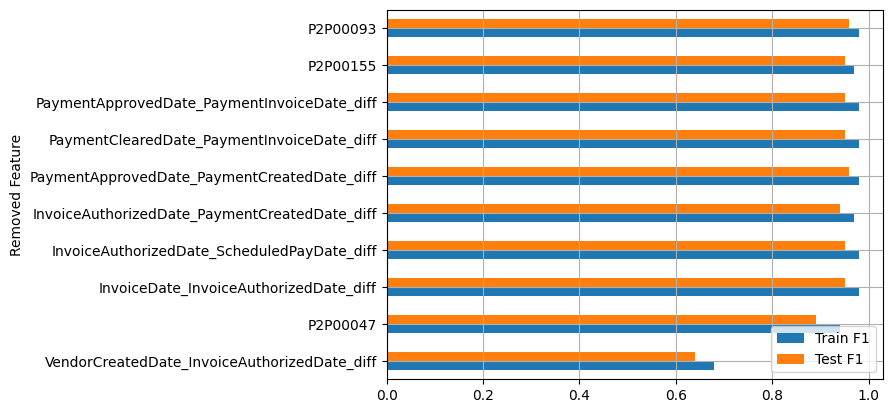

In [48]:
feature_leakages_df = pd.DataFrame(feature_leakages, columns=['Removed Feature','Train F1', 'Test F1'])
feature_leakages_df.index = feature_leakages_df['Removed Feature']
feature_leakages_df.drop('Removed Feature',axis=1,inplace=True)
feature_leakages_df.plot.barh(grid=True)

* Check for features that are causing short bars, they should be investigated for leakage

# Feature Investigation

In [4]:
df = data_setup()
# Remove high correlation columns
high_corr_cols = ['InvoiceAuthorizedDate_PaymentClearedDate_diff',
 'InvoiceCapturedOn_PaymentApprovedDate_diff',
 'InvoiceCapturedOn_PaymentClearedDate_diff',
 'VendorCreatedDate_InvoicePaymentDate_diff',
 'InvoiceAuthorizedDate_PaymentInvoiceDate_diff',
 'InvoiceDate_ScheduledPayDate_diff',
 'InvoiceAuthorizedDate_PaymentApprovedDate_diff',
 'InvoiceCapturedOn_ScheduledPayDate_diff',
 'InvoiceCapturedOn_InvoicePaymentDate_diff',
 'InvoiceAuthorizedDate_PaymentDate_diff',
 'PaymentApprovedDate_PaymentClearedDate_diff',
 'PaymentCreatedDate_PaymentInvoiceDate_diff',
 'InvoiceCapturedOn_PaymentInvoiceDate_diff',
 'InvoiceAuthorizedDate_InvoicePaymentDate_diff',
 'VendorCreatedDate_InvoiceDate_diff',
 'P2P00089',
 'PaymentDate_PaymentApprovedDate_diff',
 'PaymentDate_PaymentCreatedDate_diff',
 'InvoiceCapturedOn_PaymentCreatedDate_diff',
 'VendorCreatedDate_ScheduledPayDate_diff',
 'VendorCountry_cpi_rank',
 'InvoiceDate_InvoiceCapturedOn_diff',
 'P2P00123',
 'PaymentDate_PaymentInvoiceDate_diff',
 'VendorCreatedDate_InvoiceCapturedOn_diff',
 'InvoiceCapturedOn_PaymentDate_diff',
 'PaymentCreatedDate_PaymentClearedDate_diff',
 'InvoiceDate_InvoicePaymentDate_diff']

# Remove some other columns
df.drop(['SPT_RowID', 
         'type_of_target',
 'RemitAddress',
 'duplicate_invoice_category',
 'PaymentCurrencyCode_rank',
 'RemitCountry_rank',
 'duplicate_payment_category'], axis=1, inplace=True)

df = df.drop(high_corr_cols, axis=1)
print(f"Remaining columns {len(df.columns)}")
print(df.columns.tolist())

Cooper dataset size (889142, 83)
ABB dataset size (4273130, 77)
Combined dataset size (5162272, 62)
Total data size 4.0 GB
Total columns 62
data_setup took 15 seconds
Remaining columns 27
['P2P00047', 'InvoiceDate_InvoiceAuthorizedDate_diff', 'duplicate_payment_count', 'P2P00093', 'PaymentApprovedDate_PaymentInvoiceDate_diff', 'P2P00086', 'PaymentClearedDate_PaymentInvoiceDate_diff', 'P2P00121', 'Recurring_AmountValue', 'duplicate_invoice_count', 'PaymentApprovedDate_PaymentCreatedDate_diff', 'InvoiceAuthorizedDate_ScheduledPayDate_diff', 'P2P00003', 'P2P00088', 'Recurring_no_of_payments', 'P2P00155', 'InvoiceAuthorizedDate_PaymentCreatedDate_diff', 'P2P00073', 'VendorCreatedDate_InvoiceAuthorizedDate_diff', 'P2P00161', 'PaymentCurrencyCode_cpi_rank', 'P2P00074', 'InvoiceCapturedOn_InvoiceAuthorizedDate_diff', 'P2P00149', 'P2P00024', 'target', 'P2P00160']


In [5]:
feature_to_investigate = 'VendorCreatedDate_InvoiceAuthorizedDate_diff'

In [11]:
df[[feature_to_investigate,'target']].groupby('target').describe().unstack(1).reset_index()

,level_0,level_1,target,0
0,VendorCreatedDate_InvoiceAuthorizedDate_diff,count,0,5.000086e+06
1,VendorCreatedDate_InvoiceAuthorizedDate_diff,count,1,1.621860e+05
2,VendorCreatedDate_InvoiceAuthorizedDate_diff,mean,0,3.108789e+03
3,VendorCreatedDate_InvoiceAuthorizedDate_diff,mean,1,4.072333e+03
4,VendorCreatedDate_InvoiceAuthorizedDate_diff,std,0,2.639276e+03
5,VendorCreatedDate_InvoiceAuthorizedDate_diff,std,1,1.482336e+03
6,VendorCreatedDate_InvoiceAuthorizedDate_diff,min,0,0.000000e+00
7,VendorCreatedDate_InvoiceAuthorizedDate_diff,min,1,6.000000e+00
8,VendorCreatedDate_InvoiceAuthorizedDate_diff,25%,0,1.477000e+03
9,VendorCreatedDate_InvoiceAuthorizedDate_diff,25%,1,3.916000e+03


<AxesSubplot: >

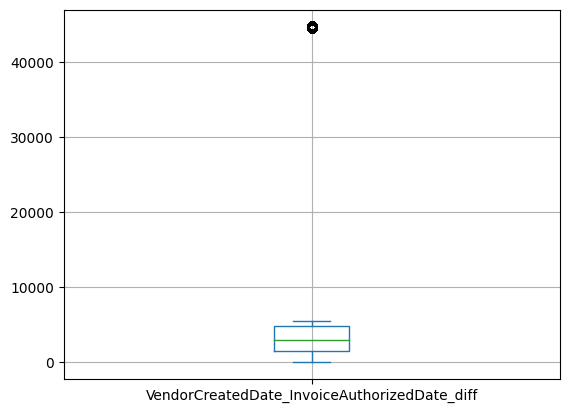

In [70]:
df[feature_to_investigate].plot.box(grid=True)

VendorCreatedDate_InvoiceAuthorizedDate_diff    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

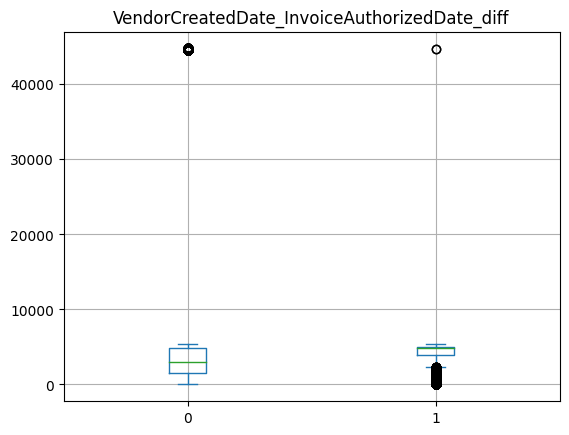

In [74]:
df = df.reset_index(drop=True)
df[[feature_to_investigate,'target']].plot.box(by='target', grid=True)

target
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: VendorCreatedDate_InvoiceAuthorizedDate_diff, dtype: object

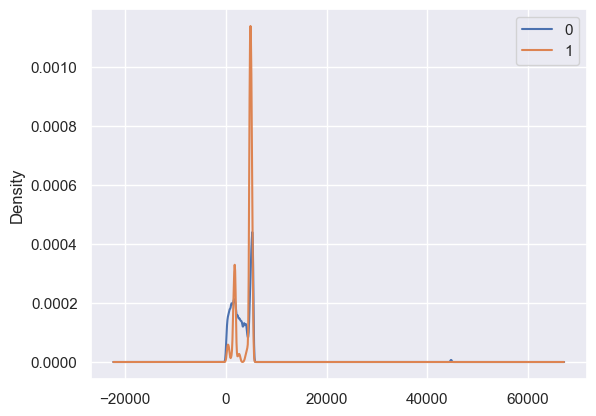

In [12]:
df[[feature_to_investigate, 'target']].groupby('target')[feature_to_investigate].plot.kde(grid=True, legend=True)

In [27]:
from sklearn.inspection import PartialDependenceDisplay

@print_timing
def partial_dependence(df, features=[]):
    columns_to_exclude = ['target','type_of_target','RemitCountry_rank','RemitAddress','PaymentCurrencyCode_rank','VendorCountry_cpi_rank','PaymentCurrencyCode_cpi_rank','SPT_RowID']
    train_cols = [col for col in df.columns if col not in columns_to_exclude]
    target_cols = ['target']
    
    X = df[train_cols]
    y = df[target_cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

    rf = RandomForestClassifier(
        n_estimators=10,
        min_samples_split=2,
        min_samples_leaf=2,
        max_depth=40,
        class_weight='balanced_subsample',
        bootstrap=False
    )
    rf.fit(X_train, y_train.values.ravel())
    PartialDependenceDisplay.from_estimator(rf, X_train, features, kind='individual')

d:\Users\Garwal\code\.venv\lib\site-packages\sklearn\inspection\_partial_dependence.py:153: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



partial_dependence took 11 minutes


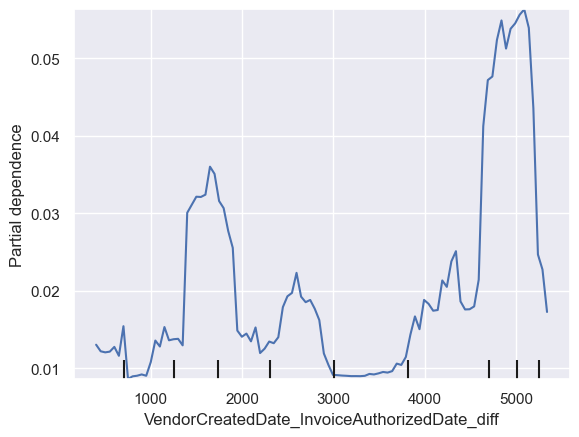

In [28]:
partial_dependence(df, features=[feature_to_investigate])

#### Forward feature selection : Using Top 5 features to train model and identify features causing target leakage

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector

rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
sfs = SequentialFeatureSelector(
    estimator=rf, 
    n_features_to_select=5,
    scoring='f1',
    direction='forward', 
    n_jobs=10)

sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(bootstrap=False,
                                                           class_weight='balanced_subsample',
                                                           max_depth=40,
                                                           min_samples_leaf=2,
                                                           n_estimators=10),
                          n_features_to_select=5, n_jobs=10, scoring='f1')

In [33]:
sfs.get_feature_names_out()

array(['InvoiceAuthorizedDate_PaymentDate_diff',
       'InvoiceCapturedOn_PaymentInvoiceDate_diff',
       'VendorCreatedDate_InvoiceDate_diff',
       'VendorCreatedDate_InvoiceAuthorizedDate_diff',
       'VendorCreatedDate_InvoicePaymentDate_diff'], dtype=object)

In [34]:
X = df[['InvoiceAuthorizedDate_PaymentDate_diff',
       'InvoiceCapturedOn_PaymentInvoiceDate_diff',
       'VendorCreatedDate_InvoiceDate_diff',
       'VendorCreatedDate_InvoiceAuthorizedDate_diff',
       'VendorCreatedDate_InvoicePaymentDate_diff']]
X = pd.get_dummies(X)
y = df[target_cols]
print(X.shape, y.shape)

(5162272, 5) (5162272, 1)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print("Training dataset",X_train.shape, y_train.shape)
print("Test dataset",X_test.shape, y_test.shape)

rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train.values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test.values)
print(classification_report(y_pred, y_test))

Training dataset (3097363, 5) (3097363, 1)
Test dataset (2064909, 5) (2064909, 1)


C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\1433914033.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train.values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1996110
           1       0.99      0.93      0.96     68799

    accuracy                           1.00   2064909
   macro avg       0.99      0.97      0.98   2064909
weighted avg       1.00      1.00      1.00   2064909



### Finding smallest subset that gives highest f1 score

In [41]:
top_5_features = ['InvoiceAuthorizedDate_PaymentDate_diff',
       'InvoiceCapturedOn_PaymentInvoiceDate_diff',
       'VendorCreatedDate_InvoiceDate_diff',
       'VendorCreatedDate_InvoiceAuthorizedDate_diff',
       'VendorCreatedDate_InvoicePaymentDate_diff']

X = df[top_5_features]
X = pd.get_dummies(X)
y = df[target_cols]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print("Training dataset",X_train.shape, y_train.shape)
print("Test dataset",X_test.shape, y_test.shape)

(5162272, 5) (5162272, 1)
Training dataset (3097363, 5) (3097363, 1)
Test dataset (2064909, 5) (2064909, 1)


In [42]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
sfs1 = SequentialFeatureSelector(
    estimator=rf, 
    n_features_to_select=1,
    scoring='f1',
    direction='forward', 
    n_jobs=10)

sfs1.fit(X_train, y_train)
print("Subset size 1:", sfs1.get_feature_names_out())

Subset size 1: ['VendorCreatedDate_InvoicePaymentDate_diff']


In [48]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train[sfs1.get_feature_names_out()].values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test[sfs1.get_feature_names_out()].values)
print(classification_report(y_pred, y_test))

C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\658994657.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train[sfs1.get_feature_names_out()].values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.91      1.00      0.95   1829787
           1       0.96      0.26      0.41    235122

    accuracy                           0.91   2064909
   macro avg       0.94      0.63      0.68   2064909
weighted avg       0.92      0.91      0.89   2064909



In [43]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)

sfs2 = SequentialFeatureSelector(
    estimator=rf, 
    n_features_to_select=2,
    scoring='f1',
    direction='forward', 
    n_jobs=10)

sfs2.fit(X_train, y_train)
print("Subset size 2:", sfs2.get_feature_names_out())

Subset size 2: ['VendorCreatedDate_InvoiceDate_diff'
 'VendorCreatedDate_InvoicePaymentDate_diff']


In [49]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train[sfs2.get_feature_names_out()].values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test[sfs2.get_feature_names_out()].values)
print(classification_report(y_pred, y_test))

C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\2879044235.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train[sfs2.get_feature_names_out()].values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1963509
           1       0.98      0.63      0.77    101400

    accuracy                           0.98   2064909
   macro avg       0.98      0.81      0.88   2064909
weighted avg       0.98      0.98      0.98   2064909



In [46]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)

sfs3 = SequentialFeatureSelector(
    estimator=rf, 
    n_features_to_select=3,
    scoring='f1',
    direction='forward', 
    n_jobs=10)

sfs3.fit(X_train, y_train)
print("Subset size 3:", sfs3.get_feature_names_out())

Subset size 3: ['InvoiceAuthorizedDate_PaymentDate_diff'
 'VendorCreatedDate_InvoiceDate_diff'
 'VendorCreatedDate_InvoicePaymentDate_diff']


In [50]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train[sfs3.get_feature_names_out()].values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test[sfs3.get_feature_names_out()].values)
print(classification_report(y_pred, y_test))

C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\3482104881.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train[sfs3.get_feature_names_out()].values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1995959
           1       0.99      0.93      0.96     68950

    accuracy                           1.00   2064909
   macro avg       0.99      0.96      0.98   2064909
weighted avg       1.00      1.00      1.00   2064909



In [47]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)

sfs4 = SequentialFeatureSelector(
    estimator=rf, 
    n_features_to_select=4,
    scoring='f1',
    direction='forward', 
    n_jobs=10)

sfs4.fit(X_train, y_train)
print("Subset size 4:", sfs4.get_feature_names_out())

Subset size 4: ['InvoiceAuthorizedDate_PaymentDate_diff'
 'InvoiceCapturedOn_PaymentInvoiceDate_diff'
 'VendorCreatedDate_InvoiceDate_diff'
 'VendorCreatedDate_InvoicePaymentDate_diff']


In [51]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train[sfs4.get_feature_names_out()].values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test[sfs4.get_feature_names_out()].values)
print(classification_report(y_pred, y_test))

C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\208858210.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train[sfs4.get_feature_names_out()].values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1996127
           1       0.99      0.93      0.96     68782

    accuracy                           1.00   2064909
   macro avg       0.99      0.96      0.98   2064909
weighted avg       1.00      1.00      1.00   2064909



### Training a model without Top 3 features

In [52]:
columns_to_exclude = ['target','type_of_target','RemitCountry_rank','RemitAddress','PaymentCurrencyCode_rank','VendorCountry_cpi_rank','PaymentCurrencyCode_cpi_rank','SPT_RowID']
train_cols = [col for col in df.columns if col not in columns_to_exclude]
train_cols = [col for col in train_cols if col not in sfs3.get_feature_names_out()]
target_cols = ['target']
print("TRAIN COLS")
for col in train_cols:
    print(col)
print("TARGET COLS", target_cols)

TRAIN COLS
PaymentDate_PaymentCreatedDate_diff
P2P00073
PaymentCreatedDate_PaymentClearedDate_diff
P2P00088
P2P00089
VendorCreatedDate_InvoiceCapturedOn_diff
InvoiceCapturedOn_ScheduledPayDate_diff
Recurring_AmountValue
P2P00121
InvoiceCapturedOn_InvoiceAuthorizedDate_diff
PaymentApprovedDate_PaymentInvoiceDate_diff
InvoiceCapturedOn_InvoicePaymentDate_diff
PaymentDate_PaymentInvoiceDate_diff
P2P00086
P2P00149
InvoiceCapturedOn_PaymentInvoiceDate_diff
P2P00160
InvoiceAuthorizedDate_PaymentInvoiceDate_diff
duplicate_invoice_count
VendorCreatedDate_InvoiceAuthorizedDate_diff
InvoiceDate_InvoiceAuthorizedDate_diff
InvoiceAuthorizedDate_PaymentCreatedDate_diff
P2P00123
P2P00047
PaymentDate_PaymentApprovedDate_diff
duplicate_invoice_category
InvoiceDate_InvoicePaymentDate_diff
duplicate_payment_category
Recurring_no_of_payments
duplicate_payment_count
PaymentApprovedDate_PaymentCreatedDate_diff
PaymentClearedDate_PaymentInvoiceDate_diff
P2P00161
InvoiceAuthorizedDate_PaymentApprovedDate_dif

In [53]:
X = df[train_cols]
X = pd.get_dummies(X)
y = df[target_cols]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print("Training dataset",X_train.shape, y_train.shape)
print("Test dataset",X_test.shape, y_test.shape)

(5162272, 86) (5162272, 1)
Training dataset (3097363, 86) (3097363, 1)
Test dataset (2064909, 86) (2064909, 1)


In [54]:
rf = RandomForestClassifier(
    n_estimators=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='auto',
    max_depth=40,
    class_weight='balanced_subsample',
    bootstrap=False
)
rf.fit(X_train.values, y_train.values.reshape(-1,1))

y_pred = rf.predict(X_test.values)
print(classification_report(y_pred, y_test))

C:\Users\Rchauhan\AppData\Local\Temp\ipykernel_85168\2173782654.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train.values, y_train.values.reshape(-1,1))
D:\Users\Rohan\repo_new\KonaAI_ML\code\.venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1999228
           1       0.98      0.97      0.97     65681

    accuracy                           1.00   2064909
   macro avg       0.99      0.98      0.99   2064909
weighted avg       1.00      1.00      1.00   2064909

